# Tutorial 2.5: Three-Body Potential Energy Surface

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

## 2.5.0 Definitions and Imports

In [1]:
%run Tutorial_2_Imports.ipynb

In [2]:
%run Tutorial_2_Paths.ipynb

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's generate the second set of configurations for our training set, those from metadynamics configurations.

## 2.5.1 Normal Modes Configuration Generation

In [3]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
minimized_structure_CH3NH2, minimized_energy_CH3NH2 = read_system_and_energy(definition_CH3NH2, paths.structures.minimized_CH3NH2)

definition_H2O = read_definition(paths.definitions.systems.H2O)
minimized_structure_H2O, minimized_energy_H2O = read_system_and_energy(definition_H2O, paths.structures.minimized_H2O)

definition_CH3NH2_H2O_H2O = read_definition(paths.definitions.systems.CH3NH2_H2O_H2O)

In [4]:
clusters_CH3NH2_H2O_H2O = read_systems(definition_CH3NH2_H2O_H2O, paths.clusters.CH3NH2_H2O_H2O)
vibrational_modes_clusters_CH3NH2_H2O_H2O = read_multiple_vibrational_modes(paths.clusters.CH3NH2_H2O_H2O_modes)

In [5]:
configurations_vibrational_modes_CH3NH2_H2O_H2O = []

for cluster, modes in zip(clusters_CH3NH2_H2O_H2O, vibrational_modes_clusters_CH3NH2_H2O_H2O):
    configuration_generator = NormalModesConfigurationGenerator(
            cluster,
            modes,
            distribution="linear",
            temperature=(10, 150)
    )

    configs = list(configuration_generator.generate_configurations(num_configs=150, seed=54321))
    configurations_vibrational_modes_CH3NH2_H2O_H2O.extend(configs)
    
write_systems(paths.PIP_CH3NH2_H2O_H2O.configs.vibrational_modes, configurations_vibrational_modes_CH3NH2_H2O_H2O)

Single negative frequency detected in input. This most likely means the given geometry is a transition state.
Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 150 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 150 configs.
Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 150 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 150 configs.
Will generate configurations over a linear temperature

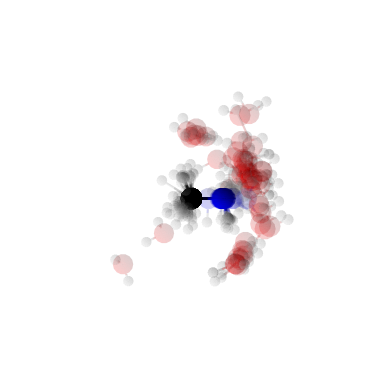

In [6]:
render_overlayed_systems(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[1].point),
    alpha=0.1,
    num_to_show=25
)

Let's generate the second set of configurations for our training set, those from metadynamics configurations.

## 2.5.2 Random Distance 

In [7]:
vibrational_modes_CH3NH2 = read_vibrational_modes(paths.structures.vibrational_modes_CH3NH2)

In [8]:
vibrational_modes_H2O = read_vibrational_modes(paths.structures.vibrational_modes_H2O)

In [9]:
generator_CH3NH2 = NormalModesConfigurationGenerator(
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
)

monomer_configs_CH3NH2 = list(generator_CH3NH2.generate_configurations(num_configs=500, seed=54321))

Will generate configurations over a piecewise temperature distribution.
Temp Distribution: temp (au) = x < 0.05 : 0.0001644078210115607 | x < 0.45 : 0.0008220391050578035 | x < 0.75 : 0.001644078210115607 | x < 0.95 : 0.003288156420231214 | otherwise : 0.008220391050578035 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 500 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 500 configs.


In [10]:
generator_H2O = NormalModesConfigurationGenerator(
        minimized_structure_H2O,
        vibrational_modes_H2O,
)

monomer_configs_H2O = list(generator_H2O.generate_configurations(num_configs=500, seed=54321))

Will generate configurations over a piecewise temperature distribution.
Temp Distribution: temp (au) = x < 0.05 : 0.00017994063671326814 | x < 0.45 : 0.0008997031835663407 | x < 0.75 : 0.0017994063671326814 | x < 0.95 : 0.0035988127342653628 | otherwise : 0.008997031835663407 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 500 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 500 configs.


In [11]:
# config_generator = RandomDistanceAndRotationConfigurationGenerator(
#         [monomer_configs_CH3NH2, monomer_configs_H2O, monomer_configs_H2O],
#         radius=7.0,
#         min_intermolecular_distance_factor=0.8,
#         logarithmic=True,
#         use_pools=True,
#         num_attempts=100
# )

# random_configs_CH3NH2_H2O_H2O = list(config_generator.generate_configurations(
#         num_configs=3000,
#         seed=12345,
# ))

# write_systems(paths.PIP_CH3NH2_H2O_H2O.configs.random, random_configs_CH3NH2_H2O_H2O)

random_configs_CH3NH2_H2O_H2O = read_systems(definition_CH3NH2_H2O_H2O, paths.PIP_CH3NH2_H2O_H2O.configs.random)

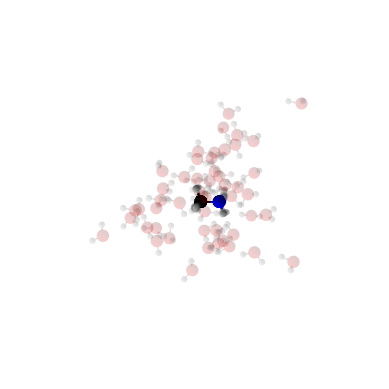

In [12]:
render_overlayed_systems(
    random_configs_CH3NH2_H2O_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[1].point),
    alpha=0.1,
    num_to_show=25
)

## 2.5.3 Parallel-Bias Metadynamics Configuration Generation

In [13]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        clusters_CH3NH2_H2O_H2O[0]
)

In [14]:
bond_params

{('A', 'B'): (90, 1.0902050169001265),
 ('A', 'C'): (150, 1.4840322105456125),
 ('C', 'D'): (90, 1.0353028491290241),
 ('E', 'F'): (90, 0.9895932815834846)}

In [15]:
angle_params

{('F', 'E', 'F'): (10, 101.39053903964934),
 ('B', 'A', 'B'): (10, 108.17230750568437),
 ('B', 'A', 'C'): (10, 110.72902281270156),
 ('A', 'C', 'D'): (10, 108.23645918194089),
 ('D', 'C', 'D'): (10, 105.73773276456467)}

In [16]:
nonbonded_params

{'A': (0.03, 2.2),
 'B': (0.01, 1.2),
 'C': (0.03, 2.2),
 'D': (0.01, 1.2),
 'E': (0.03, 2.2),
 'F': (0.01, 1.2)}

In [17]:
charges = read_parameters(paths.Vphys.charges)
charges = {symmetry: charges[symmetry]*1/3 for symmetry in charges}
charges["E"] = -0.6*1/3
charges["F"] = +0.3*1/3

In [18]:
perform_pbmetad_simulation(
        lammps_executable_path,
        [minimized_structure_CH3NH2, minimized_structure_H2O, minimized_structure_H2O],
        num_configs=500000,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool,
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=paths.scratch.pbmetad_CH3NH2_H2O_H2O,
        restart_path=paths.restart.pbmetad_CH3NH2_H2O_H2O,
        min_intermolecular_distance=1.5,
        max_intermolecular_distance=6
)

PBMetaD already completed. Will not rerun!


In [19]:
inner_cutoff_3b = 4.5
outer_cutoff_3b = 5.5

In [20]:
num_filtered_configs = filter_configs_by_cutoff(
        definition_CH3NH2_H2O_H2O,
        paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool,
        threshold=outer_cutoff_3b,
        filtered_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool_filtered
)

Found 212554 within cutoff distance of 5.5


In [21]:
split_pool(
        definition_CH3NH2_H2O_H2O,
        paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool_filtered,
        pool_size=num_filtered_configs,
        num_configs_to_split=200,
        unsplit_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train_pool,
        split_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_test,
        strategy="INTERVAL",
)

In [22]:
pbmetad_configs_CH3NH2_H2O_H2O = perform_fps(
        definition_CH3NH2_H2O_H2O,
        clusters_CH3NH2_H2O_H2O[0],
        vibrational_modes_clusters_CH3NH2_H2O_H2O[0],
        paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train_pool,
        num_pool_configs=num_filtered_configs-200,
        num_phase1_input_configs=100000,
        approx_configs_to_select=3000,
        fps_workdir=paths.scratch.fps_CH3NH2_H2O_H2O,
        restart_path=paths.restart.fps_CH3NH2_H2O_H2O,
        num_threads=16
)

Phase1 already complete. Will not rerun.
Phase2 already complete. Will not rerun.
Selected 3405 total configs by FPS.


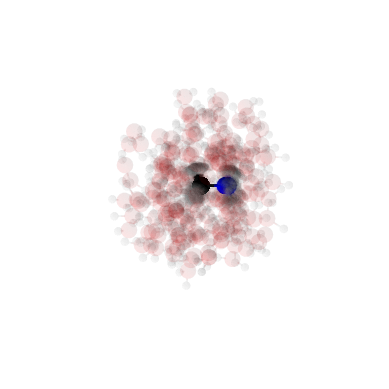

In [23]:
render_overlayed_systems(
    pbmetad_configs_CH3NH2_H2O_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.05,
    num_to_show=100
)

In [24]:
write_systems(paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train, pbmetad_configs_CH3NH2_H2O_H2O)

## 2.5.4 Energy Calculation

In [25]:
calculator = Psi4Calculator(
        "MP2",
        "def2-TZVP",
        log_directory=str(paths.logs),
        scratch_directory=str(paths.scratch.psi4)
)

In [26]:
energies_vibrational_modes_CH3NH2_H2O_H2O = calculate_nmer_energies(
        configurations_vibrational_modes_CH3NH2_H2O_H2O,
        calculator,
        paths.restart.energies_vibrational_mode_configs_CH3NH2_H2O_H2O,
        num_threads=8,
        mem_mb=16000,
        error_on_any_failure=False,
        retrieve_only=True
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O_H2O.configs.vibrational_modes_energies, (configurations_vibrational_modes_CH3NH2_H2O_H2O, energies_vibrational_modes_CH3NH2_H2O_H2O))

Running energy calculations |====================================================================================================| - 9450/9450
Completed n-mer energy calculations!


In [27]:
energies_pbmetad_CH3NH2_H2O_H2O = calculate_nmer_energies(
        pbmetad_configs_CH3NH2_H2O_H2O,
        calculator,
        paths.restart.energies_pbmetad_configs_CH3NH2_H2O_H2O,
        num_threads=8,
        mem_mb=16000,
        error_on_any_failure=False,
        retrieve_only=True
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train_energies, (pbmetad_configs_CH3NH2_H2O_H2O, energies_pbmetad_CH3NH2_H2O_H2O))

Running energy calculations |====================================================================================================| - 23835/23835
Completed n-mer energy calculations!


In [28]:
energies_random_CH3NH2_H2O_H2O = calculate_nmer_energies(
        random_configs_CH3NH2_H2O_H2O,
        calculator,
        paths.restart.energies_random_configs_CH3NH2_H2O_H2O,
        num_threads=4,
        mem_mb=8000,
        error_on_any_failure=False,
        retrieve_only=True,
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O_H2O.configs.random_energies, (random_configs_CH3NH2_H2O_H2O, energies_random_CH3NH2_H2O_H2O))

Running energy calculations |====================================================================================================| - 21000/21000
Completed n-mer energy calculations!


In [29]:
configurations_vibrational_modes_CH3NH2_H2O_H2O, energies_vibrational_modes_CH3NH2_H2O_H2O = discard_failed_configurations(
        configurations_vibrational_modes_CH3NH2_H2O_H2O,
        energies_vibrational_modes_CH3NH2_H2O_H2O
)

pbmetad_configs_CH3NH2_H2O_H2O, energies_pbmetad_CH3NH2_H2O_H2O = discard_failed_configurations(
        pbmetad_configs_CH3NH2_H2O_H2O,
        energies_pbmetad_CH3NH2_H2O_H2O
)

random_configs_CH3NH2_H2O_H2O, energies_random_CH3NH2_H2O_H2O = discard_failed_configurations(
        random_configs_CH3NH2_H2O_H2O,
        energies_random_CH3NH2_H2O_H2O
)

Checking for missing energies |====================================================================================================| - 1350/1350
Found 19 systems with one or more missing n-mer energies. Remaining configurations: 1331
Checking for missing energies |====================================================================================================| - 3405/3405
Found 0 systems with one or more missing n-mer energies. Remaining configurations: 3405
Checking for missing energies |====================================================================================================| - 3000/3000
Found 0 systems with one or more missing n-mer energies. Remaining configurations: 3000


In [30]:
energies_3b_vibrational_modes_CH3NH2_H2O_H2O = calculate_many_body_energies(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    energies_vibrational_modes_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

energies_3b_pbmetad_CH3NH2_H2O_H2O = calculate_many_body_energies(
    pbmetad_configs_CH3NH2_H2O_H2O,
    energies_pbmetad_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

energies_3b_random_CH3NH2_H2O_H2O = calculate_many_body_energies(
    random_configs_CH3NH2_H2O_H2O,
    energies_random_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

In [31]:
energies_binding_vibrational_modes_CH3NH2_H2O_H2O = calculate_binding_energies(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    energies_vibrational_modes_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

energies_binding_pbmetad_CH3NH2_H2O_H2O = calculate_binding_energies(
    pbmetad_configs_CH3NH2_H2O_H2O,
    energies_pbmetad_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

energies_binding_random_CH3NH2_H2O_H2O = calculate_binding_energies(
    random_configs_CH3NH2_H2O_H2O,
    energies_random_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

In [32]:
write_training_set_file(
        paths.PIP_CH3NH2_H2O_H2O.training_set,
        (
                [*configurations_vibrational_modes_CH3NH2_H2O_H2O, *pbmetad_configs_CH3NH2_H2O_H2O, *random_configs_CH3NH2_H2O_H2O],
                [*energies_binding_vibrational_modes_CH3NH2_H2O_H2O, *energies_binding_pbmetad_CH3NH2_H2O_H2O, *energies_binding_random_CH3NH2_H2O_H2O],
                [*energies_3b_vibrational_modes_CH3NH2_H2O_H2O, *energies_3b_pbmetad_CH3NH2_H2O_H2O, *energies_3b_random_CH3NH2_H2O_H2O],
        )
)
print(f"Total configurations for training set: {len(configurations_vibrational_modes_CH3NH2_H2O_H2O) + len(pbmetad_configs_CH3NH2_H2O_H2O) + len(random_configs_CH3NH2_H2O_H2O)}")

Total configurations for training set: 7736


## 2.5.5 Polynomial Generation

In [36]:
pip_3b_max_order = 3

In [122]:
generate_polynomial(
        definition_CH3NH2_H2O_H2O,
        max_degree=pip_3b_max_order,
        polynomial_info_path=paths.PIP_CH3NH2_H2O_H2O.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.polynomial,
        filters=[
                "add_filter['sum-degree', 'x-inter-*+*-*', '0']",
                "add_filter['sum-degree', 'x-intra-*+*-*', '2+']",
                "add_filter['sum-degree', 'x-*-*+B-*/x-*-*+D-*/x-*-*+F-*', '3+']",
        ]
)

(A1B3C1D2)_(E1F2)_(E1F2)
Generating polynomial input file for symmetry (A1B3C1D2)_(E1F2)_(E1F2) into file Tutorial_2_workdir/PIP_CH3NH2_H2O_H2O/PIP/info.in.
Successfully generated polynomial input file! 78 total variables.
File Tutorial_2_workdir/PIP_CH3NH2_H2O_H2O/PIP/polynomial/poly.log already exists, moving existing Tutorial_2_workdir/PIP_CH3NH2_H2O_H2O/PIP/polynomial/poly.log to Tutorial_2_workdir/PIP_CH3NH2_H2O_H2O/PIP/polynomial/poly.log.backup-7 to make way for new file.
Generating terms up to degree 3...
Generating polynomial: |====================================================================================================| - 234/234
21 possible degree 1 terms, now filtering them...
There were 11 accepted degree 1 terms.
371 possible degree 2 terms, now filtering them...
There were 295 accepted degree 2 terms.
5541 possible degree 3 terms, now filtering them...
There were 1363 accepted degree 3 terms.
There were 1669 accepted terms over all
Writing Gradients C++: |========

## 2.5.6 Polynomial Parametrization

In [33]:
polarizabilities = read_parameters(paths.Vphys.polarizabilities)
polarizability_factors = read_parameters(paths.Vphys.polarizability_factors)
charges = read_parameters(paths.Vphys.charges)
C6 = read_parameters(paths.Vphys.C6)
d6 = read_parameters(paths.Vphys.d6)

In [34]:
print("polarizabilities:", polarizabilities)
print("polarizability_factors:", polarizability_factors)
print("charges:", charges)
print("C6:", C6)
print("d6:", d6)

polarizabilities: {'A': 1.197286837688588, 'B': 0.3338549392278207, 'C': 0.936690107093768, 'D': 0.35079895087010643, 'E': 1.31, 'F': 0.294}
polarizability_factors: {'A': 1.197286837688588, 'B': 0.3338549392278207, 'C': 0.936690107093768, 'D': 0.35079895087010643, 'E': 1.31, 'F': 0.294}
charges: {'A': 0.19712181192295436, 'B': -0.007316083425489981, 'C': -0.6523113428259786, 'D': 0.2385688905897471}
C6: {('A', 'E'): 213.33108737196045, ('A', 'F'): 101.90479632213754, ('A', 'A'): 287.58772280972653, ('A', 'B'): 100.71518361858206, ('A', 'C'): 245.27149949753883, ('A', 'D'): 101.84278948237693, ('B', 'E'): 81.0911671091582, ('B', 'F'): 37.128317718883046, ('B', 'B'): 36.90402137258849, ('B', 'C'): 89.56084211053388, ('B', 'D'): 37.054828131018624, ('C', 'E'): 196.20342030030648, ('C', 'F'): 90.13727606534552, ('C', 'C'): 217.4097594984364, ('C', 'D'): 89.97192449265054, ('D', 'E'): 80.93270518532552, ('D', 'F'): 37.3074485893026, ('D', 'D'): 37.24888657397313, ('E', 'E'): 237.32122141479

In [ ]:
generate_pip_parametizer(
        definition_CH3NH2_H2O_H2O,
        max_degree=pip_3b_max_order,
        polynomial_info_path=paths.PIP_CH3NH2_H2O_H2O.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.polynomial,
        parametizer_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.parameterizer,
        workdir=paths.scratch.PIP_CH3NH2_H2O_H2O,
        symmetry_to_charge=charges,
        symmetry_to_polarizability=polarizabilities,
        symmetry_to_polarizability_factor=polarizability_factors,
        symmetries_to_C6=C6,
        symmetries_to_d6=d6,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        is_mbpol=[False, True, True],
        inner_cutoff=inner_cutoff_3b,
        outer_cutoff=outer_cutoff_3b
)

In [ ]:
parametrize_pip(
        definition_CH3NH2_H2O_H2O,
        parametizer_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.parameterizer,
        parametrization_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.parametrization,
        training_set_path=paths.PIP_CH3NH2_H2O_H2O.training_set,
        workdir=paths.scratch.fitting_CH3NH2_H2O_H2O,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        is_mbpol=[False, True, True],
        num_fits_to_run=1,
        num_threads=16,
        DE=10,
        alpha=0.0005
)

Succesfully created fit folder fit1.
fit1 is running.



## 2.5.7 Implementation in MBX

In [37]:
add_PIP_to_MBX(
        paths.MBX,
        definition_CH3NH2_H2O_H2O,
        ["ch3nh2", "h2o", "h2o"],
        paths.PIP_CH3NH2_H2O_H2O.PIP.parameterizer,
        paths.PIP_CH3NH2_H2O_H2O.PIP.parametrization,
        max_degree=pip_3b_max_order,
        workdir=paths.scratch.fitting_CH3NH2_H2O_H2O,
)

Getting polynomial fitted parameters...
Getting energy calls...


In [ ]:
compile_mbx(
        paths.MBX,
        configure_arguments=[
                "CXX=icpc",
                "CC=icc",
                "--disable-optimization"
        ],
        configure=True,
        clean=False,
        num_threads=4
)

## 2.4.8 Correlation & Validation

In [39]:
predicted_energies_vibrational_modes_CH3NH2_H2O_H2O = calculate_MBX_nmer_energies(
        paths.MBX,
        definition_CH3NH2_H2O_H2O,
        configurations_vibrational_modes_CH3NH2_H2O_H2O,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O_H2O
)

MBX energy calculations: |====================================================================================================| - 9317/9317


In [40]:
predicted_energies_pbmetad_CH3NH2_H2O_H2O = calculate_MBX_nmer_energies(
        paths.MBX,
        definition_CH3NH2_H2O_H2O,
        pbmetad_configs_CH3NH2_H2O_H2O,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O_H2O
)

MBX energy calculations: |====================================================================================================| - 23835/23835


In [41]:
predicted_energies_random_CH3NH2_H2O_H2O = calculate_MBX_nmer_energies(
        paths.MBX,
        definition_CH3NH2_H2O_H2O,
        random_configs_CH3NH2_H2O_H2O,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O_H2O
)

MBX energy calculations: |====================================================================================================| - 21000/21000


In [42]:
mbx_opt_CH3NH2_energy = calculate_MBX_energy(
        paths.MBX,
        definition_CH3NH2,
        minimized_structure_CH3NH2,
        monomer_names=["ch3nh2"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O
)

In [43]:
mbx_opt_H2O_energy = calculate_MBX_energy(
        paths.MBX,
        definition_H2O,
        minimized_structure_H2O,
        monomer_names=["h2o"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O
)

In [46]:
predicted_energies_3b_vibrational_modes_CH3NH2_H2O_H2O = calculate_many_body_energies(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    predicted_energies_vibrational_modes_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[mbx_opt_CH3NH2_energy, mbx_opt_H2O_energy, mbx_opt_H2O_energy]
)

predicted_energies_3b_pbmetad_CH3NH2_H2O_H2O = calculate_many_body_energies(
    pbmetad_configs_CH3NH2_H2O_H2O,
    predicted_energies_pbmetad_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[mbx_opt_CH3NH2_energy, mbx_opt_H2O_energy, mbx_opt_H2O_energy]
)

predicted_energies_3b_random_CH3NH2_H2O_H2O = calculate_many_body_energies(
    random_configs_CH3NH2_H2O_H2O,
    predicted_energies_random_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[mbx_opt_CH3NH2_energy, mbx_opt_H2O_energy, mbx_opt_H2O_energy]
)

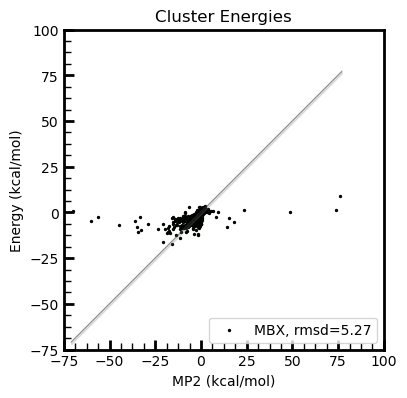

In [47]:
plot_correlation(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    energies_3b_vibrational_modes_CH3NH2_H2O_H2O,
    "MP2",
    {"MBX": predicted_energies_3b_vibrational_modes_CH3NH2_H2O_H2O},
    error_width=1.0
)

In [74]:
def filter_by_bind(a, b):
    return [ai for ai, bi in zip(a, b) if bi < 10]

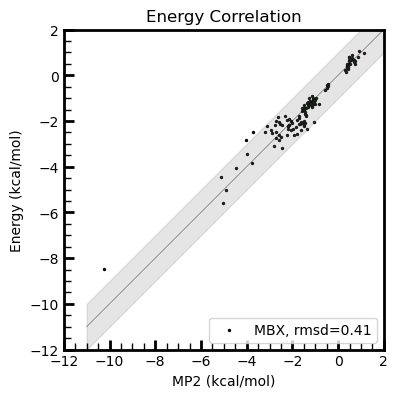

In [75]:
plot_correlation(
    filter_by_bind(configurations_vibrational_modes_CH3NH2_H2O_H2O, energies_binding_vibrational_modes_CH3NH2_H2O_H2O),
    filter_by_bind(energies_3b_vibrational_modes_CH3NH2_H2O_H2O, energies_binding_vibrational_modes_CH3NH2_H2O_H2O),
    "MP2",
    {"MBX": filter_by_bind(predicted_energies_3b_vibrational_modes_CH3NH2_H2O_H2O, energies_binding_vibrational_modes_CH3NH2_H2O_H2O)},
    error_width=1.0
)

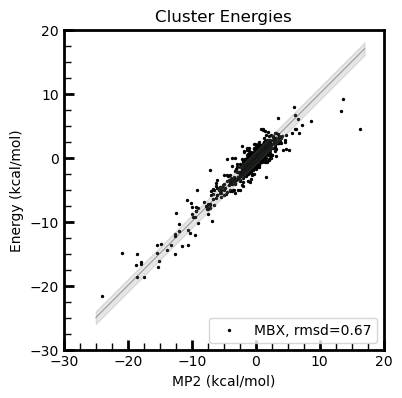

In [50]:
plot_correlation(
    pbmetad_configs_CH3NH2_H2O_H2O,
    energies_3b_pbmetad_CH3NH2_H2O_H2O,
    "MP2",
    {"MBX": predicted_energies_3b_pbmetad_CH3NH2_H2O_H2O},
    error_width=1.0
)

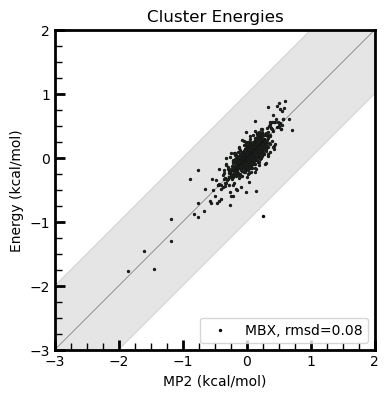

In [51]:
plot_correlation(
    random_configs_CH3NH2_H2O_H2O,
    energies_3b_random_CH3NH2_H2O_H2O,
    "MP2",
    {"MBX": predicted_energies_3b_random_CH3NH2_H2O_H2O},
    error_width=1.0
)

In [67]:
scan_CH3NH2_H2O_H2O_1, scan_CH3NH2_H2O_H2O_1_energies = read_systems_and_nmer_energies(definition_CH3NH2_H2O_H2O, paths.scans.CH3NH2_H2O_H2O.first_energies)
scan_CH3NH2_H2O_H2O_2, scan_CH3NH2_H2O_H2O_2_energies = read_systems_and_nmer_energies(definition_CH3NH2_H2O_H2O, paths.scans.CH3NH2_H2O_H2O.second_energies)
scan_CH3NH2_H2O_H2O_3, scan_CH3NH2_H2O_H2O_3_energies = read_systems_and_nmer_energies(definition_CH3NH2_H2O_H2O, paths.scans.CH3NH2_H2O_H2O.third_energies)

In [68]:
scan_CH3NH2_H2O_H2O_1_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_1, scan_CH3NH2_H2O_H2O_1_energies)
scan_CH3NH2_H2O_H2O_2_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_2, scan_CH3NH2_H2O_H2O_2_energies)
scan_CH3NH2_H2O_H2O_3_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_3, scan_CH3NH2_H2O_H2O_3_energies)

In [58]:
predicted_scan_CH3NH2_H2O_H2O_1_energies = calculate_MBX_nmer_energies(
        paths.MBX,
        definition_CH3NH2_H2O_H2O,
        scan_CH3NH2_H2O_H2O_1,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O_H2O
)
predicted_scan_CH3NH2_H2O_H2O_2_energies = calculate_MBX_nmer_energies(
        paths.MBX,
        definition_CH3NH2_H2O_H2O,
        scan_CH3NH2_H2O_H2O_2,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O_H2O
)
predicted_scan_CH3NH2_H2O_H2O_3_energies = calculate_MBX_nmer_energies(
        paths.MBX,
        definition_CH3NH2_H2O_H2O,
        scan_CH3NH2_H2O_H2O_3,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O_H2O
)

MBX energy calculations: |====================================================================================================| - 133/133
MBX energy calculations: |====================================================================================================| - 133/133
MBX energy calculations: |====================================================================================================| - 133/133


In [64]:
predicted_scan_CH3NH2_H2O_H2O_1_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_1, predicted_scan_CH3NH2_H2O_H2O_1_energies)
predicted_scan_CH3NH2_H2O_H2O_2_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_2, predicted_scan_CH3NH2_H2O_H2O_2_energies)
predicted_scan_CH3NH2_H2O_H2O_3_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_3, predicted_scan_CH3NH2_H2O_H2O_3_energies)

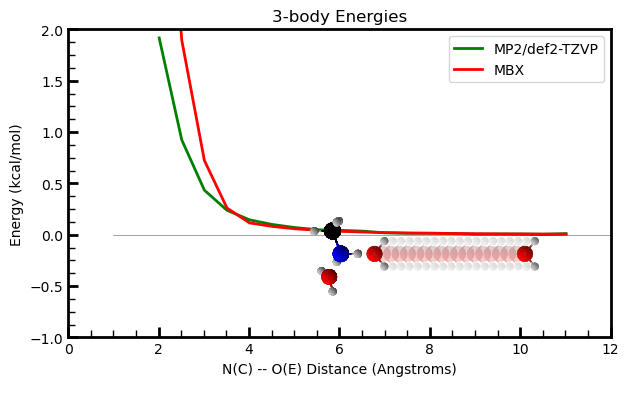

In [69]:
plot_scan(
        systems=scan_CH3NH2_H2O_H2O_1,
        energies={
                "MP2/def2-TZVP": scan_CH3NH2_H2O_H2O_1_3b_energies,
                "MBX": predicted_scan_CH3NH2_H2O_H2O_1_3b_energies
        },
        atom1_index=4,
        atom2_index=-3,
        title="3-body Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[10].point, system.atoms[0].point)
)

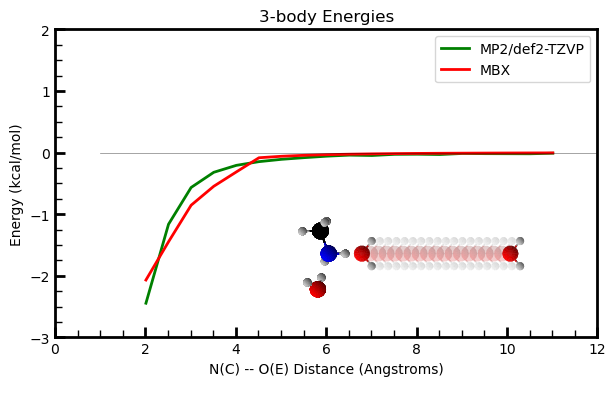

In [71]:
plot_scan(
        systems=scan_CH3NH2_H2O_H2O_2,
        energies={
                "MP2/def2-TZVP": scan_CH3NH2_H2O_H2O_2_3b_energies,
                "MBX": predicted_scan_CH3NH2_H2O_H2O_2_3b_energies
        },
        atom1_index=4,
        atom2_index=-3,
        title="3-body Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[10].point, system.atoms[0].point)
)

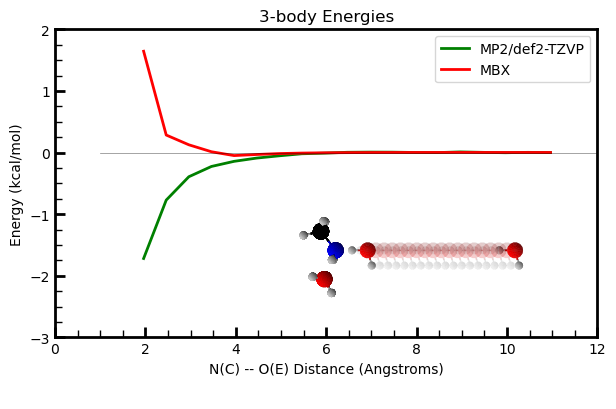

In [72]:
plot_scan(
        systems=scan_CH3NH2_H2O_H2O_3,
        energies={
                "MP2/def2-TZVP": scan_CH3NH2_H2O_H2O_3_3b_energies,
                "MBX": predicted_scan_CH3NH2_H2O_H2O_3_3b_energies
        },
        atom1_index=4,
        atom2_index=-3,
        title="3-body Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[-3].point, system.atoms[0].point)
)